In [1]:
%load_ext autoreload

In [2]:
%autoreload
import sys
sys.path.insert(0, '../')

In [3]:
from src.utilities.mluar_utils import *

/mnt/swordfish-pool2/milad/conda-envs/huggingface-tlr/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from transformers import AutoModel, AutoTokenizer
from datasets import load_dataset, Dataset
import numpy as np
from einops import rearrange, reduce, repeat
import torch
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
import math
import pandas as pd

In [5]:
xslu_taxonomy_df = pd.read_pickle('/mnt/swordfish-pool2/milad/hiatus-data/xslue-style-documents-n_samples=100.pkl')

In [6]:
MULTI_LUAR_PATH =  "/mnt/swordfish-pool2/milad/multi-luar-reddit-model/"
LUAR_PATH =  "/mnt/swordfish-pool2/nikhil/LUAR/pretrained_weights/LUAR-MUD/"

In [7]:
analyzed_labels = [
    'Formal / Informal',
    'Active / Passive',
    #'Fluent sentence / Disfluent sentence',
    #'With Humor / Without Humor',
    #'Present-focused / Past-focused',
    #'Self-focused / Inclusive-focused',
    # 'With frequent punctuation / Less Frequent punctuation',
    'Offensive / Non-Offensive',
    #'With metaphor / Without metaphor',
    #'Positive / Negative',
]

In [8]:
# Load models
multiluar_model = AutoModel.from_pretrained(MULTI_LUAR_PATH, trust_remote_code=True)
luar_model = AutoModel.from_pretrained(LUAR_PATH, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("rrivera1849/LUAR-MUD")

In [9]:
# Load data
style_distance_dataset = load_dataset('StyleDistance/synthstel')
# Create author for each style feature
author_lvl_style_dataset= merge_texts_to_authors_per_label(style_distance_dataset['train'].filter(lambda row: row['feature'] in analyzed_labels), 25)

In [10]:
np.max([len(x.split()) for x in author_lvl_style_dataset['positive']])

np.int64(74)

In [16]:
max_seq_length = 96 # longest sequence is 320
# Get embeddings from multi-luar
positives_embeddings, _ = get_luar_embeddings(author_lvl_style_dataset['positive'], multiluar_model, tokenizer, max_length=max_seq_length, batch_size=5, is_multi_luar=True)
negatives_embeddings, _ = get_luar_embeddings(author_lvl_style_dataset['negative'], multiluar_model, tokenizer, max_length=max_seq_length, batch_size=5, is_multi_luar=True)
labels = author_lvl_style_dataset['feature']

# Get embeddings from Luar
positives_luar_embeddings, _ = get_luar_embeddings(author_lvl_style_dataset['positive'], luar_model, tokenizer, max_length=max_seq_length, batch_size=5)
negatives_luar_embeddings, _ = get_luar_embeddings(author_lvl_style_dataset['negative'], luar_model, tokenizer, max_length=max_seq_length, batch_size=5)
positives_luar_embeddings = [e.unsqueeze(0) for e in positives_luar_embeddings]
negatives_luar_embeddings = [e.unsqueeze(0) for e in negatives_luar_embeddings]

In [17]:
# Just put all sentences together 
all_embeddings = positives_embeddings + negatives_embeddings
all_labels  = [x.split('/')[0] for x in labels] + [x.split('/')[1] for x in labels]

In [18]:
# Compute distance and cosine similarities

# Compute Multi-luar similarity matrices at every layer and average of the layers
muti_luar_layers_sims = [compute_similarities(positives_embeddings, negatives_embeddings, layer=i) for i in range(7)]
muti_luar_layers_sims.append(compute_similarities(positives_embeddings, negatives_embeddings, layer=None))

# Compute Luar similarity matrices (only final layer)
luar_sim_matrix = compute_similarities(positives_embeddings, negatives_embeddings, layer=None)

muti_luar_layers_dist = [compute_distances(positives_embeddings, negatives_embeddings, layer=i) for i in range(7)]
muti_luar_layers_dist.append(compute_distances(positives_embeddings, negatives_embeddings, layer=None))

In [19]:
compute_mrr(luar_sim_matrix, all_labels)

np.float64(0.3)

In [21]:
[compute_mrr(s, all_labels) for s in muti_luar_layers_sims]

[np.float64(0.291),
 np.float64(0.292),
 np.float64(0.285),
 np.float64(0.315),
 np.float64(0.315),
 np.float64(0.321),
 np.float64(0.326),
 np.float64(0.3)]

In [22]:
# def compute_layer_to_features_significance(muti_luar_layers_sims, labels):
#     layer_to_feat_score = []
#     unique_labels = set(labels)
#     for label in unique_labels:
#         label_indices = np.where(np.array(labels) == label)[0]
#         other_labels_indices = np.where(np.array(labels) != label)[0]
#         #print(label_indices)
#         label_sims = []
#         for layer in range(7):
#             muti_luar_layer_sim = muti_luar_layers_sims[layer]
#             label_matrix = np.take(muti_luar_layer_sim, label_indices, axis=0)
#             label_matrix = np.take(label_matrix, label_indices, axis=1)

#             other_labels_matrix = np.take(muti_luar_layer_sim, other_labels_indices, axis=0)
#             other_labels_matrix = np.take(other_labels_matrix, other_labels_indices, axis=1)
            
#             #print(label_matrix)
#             label_sims.append(round(float(np.mean(label_matrix)/np.mean(other_labels_matrix)), 2))
#             #label_sims.append(round(float(np.mean(label_matrix)), 2))
#         layer_to_feat_score.append(label_sims)
#     return layer_to_feat_score

def compute_layer_to_features_significance(muti_luar_layers_sims, labels):
    layer_to_feat_score = []
    unique_labels = set(labels)
    for layer in range(7):
        label_sims = []
        for label in unique_labels:
            label_matrix = np.take(muti_luar_layers_sims[layer], np.where(np.array(labels) == label)[0], axis=0)
            label_matrix = np.take(muti_luar_layers_sims[layer], np.where(np.array(labels) == label)[0], axis=1)
            label_sims.append(np.mean(label_matrix))

            
        layer_to_feat_score.append([round(float(x)/np.mean(label_sims), 3) for x in label_sims])

    return np.array(layer_to_feat_score).transpose()

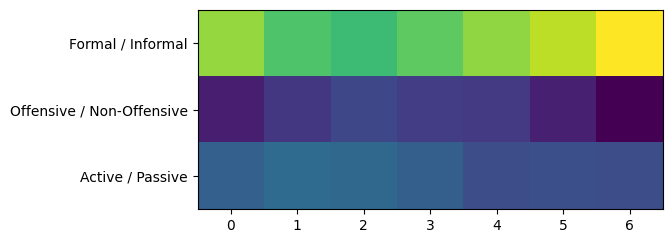

In [23]:
layer_to_feat_score = compute_layer_to_features_significance(muti_luar_layers_dist, labels)
fig, ax = plt.subplots(figsize=(6,12))
ax.imshow(layer_to_feat_score)
ax.set(yticks = range(len(set(labels))), yticklabels=set(labels))
plt.show()

In [97]:
layer_to_feat_score

array([[0.998, 0.997, 1.011, 1.009, 1.006, 1.001, 0.99 ],
       [1.002, 1.003, 0.989, 0.991, 0.994, 0.999, 1.01 ]], dtype=float32)

### Clustering

In [24]:
from sklearn.manifold import TSNE

def get_cmap(n, name='Accent'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def plot_tsne(embeddings, labels, layer):
    fig, ax = plt.subplots(figsize=(6,3))
    X =  np.array([elem.numpy() for elem in embeddings])
    X = X[:, layer, :]
    
    X_embedded = TSNE(n_components=2, learning_rate='auto',
                      init='pca', random_state=123, metric='cosine').fit_transform(X)
    x = X_embedded[:,0]
    y = X_embedded[:,1]
    
    
    label_set = list(set(labels))
    color_map = get_cmap(len(label_set))
    label_set_colors = {x: color_map(i) for i, x in enumerate(label_set)}
    label_colors = [label_set_colors[label] for label in labels]

    for i, label in enumerate(label_set):
        label_indices = np.where(np.array(labels) == label)[0]
        sc = plt.scatter(x[label_indices], y[label_indices], color=label_set_colors[label], label=label)
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

/tmp/ipykernel_4051741/19340659.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  return plt.cm.get_cmap(name, n)


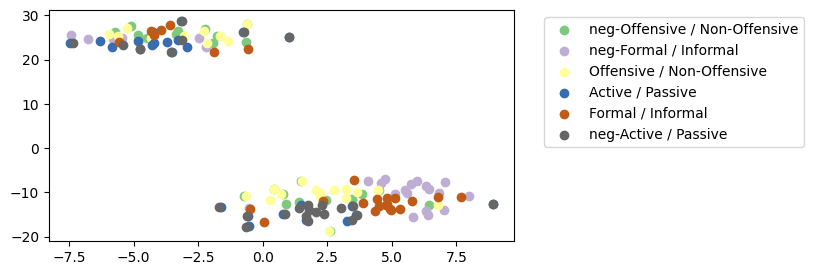

In [27]:
plot_tsne(positives_embeddings + negatives_embeddings, labels + ['neg-' + x for x in labels], layer=1)

/tmp/ipykernel_4051741/19340659.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  return plt.cm.get_cmap(name, n)


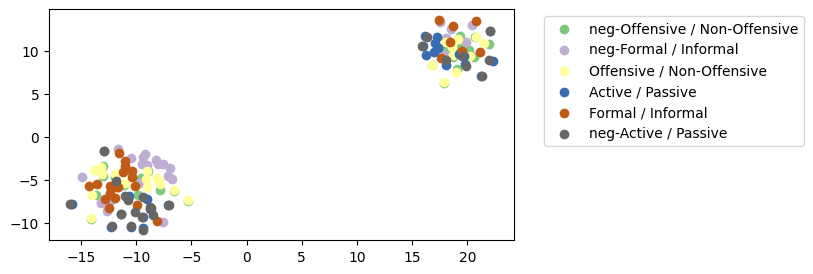

In [28]:
plot_tsne(positives_embeddings + negatives_embeddings, labels + ['neg-' + x for x in labels], layer=2)